<a href="https://colab.research.google.com/github/Xinchunran/paper_review/blob/main/ReLSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install scikit-learn wandb numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
 !pip install git+https://github.com/facebookresearch/esm.git
 !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
 !tar -xzf P62593_reprs.tar.gz
 !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
 !pwd
 !l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-v_o9_n2a
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-v_o9_n2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.0-py3-none-any.whl size=95419 sha256=1946e61b328d9dfb33a73fcecf0f7f63fa2859e72cfffeef1a19cc27fce4eeab
  Stored in directory: /tmp/pip-ephem-wheel-cache-43_gag9e/wheels/5c/8e/11/307eca5379b418a9989ef4d24ead655755f2500a577ec95208
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  14.6M      0  0:00:01  0:00:01 --:--:-- 14.6M
  % Total    % Received % Xferd  Average S

In [6]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import esm
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [7]:
FASTA_PATH = "/content/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/content/P62593_reprs/" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34


In [8]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}{header[0:]}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

5397
(5397, 1280)


In [11]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [12]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((4317, 1280), (1080, 1280), 4317, 1080)

In [13]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

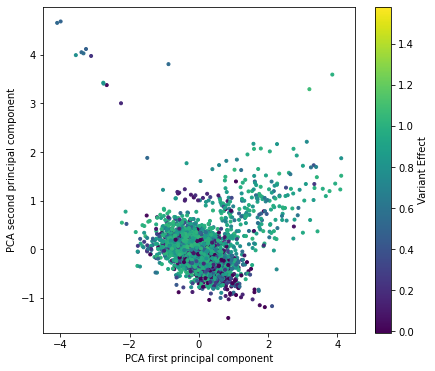

In [14]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [15]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

In [16]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

In [17]:
# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [18]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')

KNeighborsRegressor(algorithm='ball_tree', p=1, weights='distance')

SpearmanrResult(correlation=0.7907847259178541, pvalue=4.758276759453181e-232)

 -------------------------------------------------------------------------------- 

SVR()

SpearmanrResult(correlation=0.8009597745292193, pvalue=2.125585309923182e-242)

 -------------------------------------------------------------------------------- 

RandomForestRegressor(max_features='log2', min_samples_split=5, n_estimators=20)

SpearmanrResult(correlation=0.6990543038037885, pvalue=3.3683564424722167e-159)

 -------------------------------------------------------------------------------- 



In [19]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


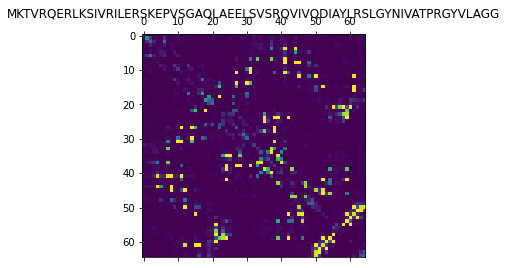

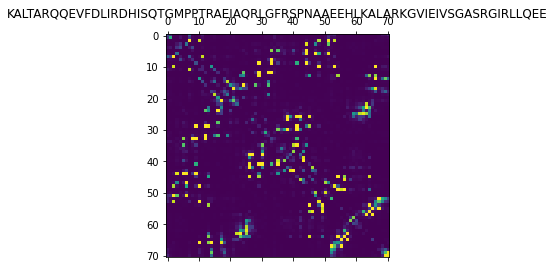

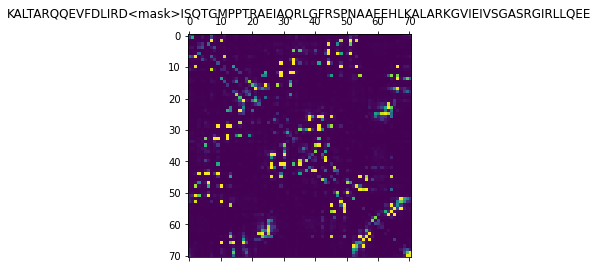

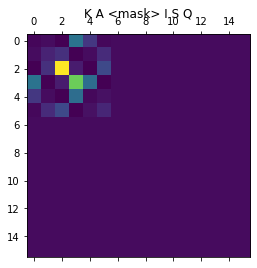

In [20]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [ ]:
!pip install fair-esm[esmfold]
# OpenFold and its remaining dependency
!pip install 'dllogger @ git+https://github.com/NVIDIA/dllogger.git'
!pip install 'openfold @ git+https://github.com/aqlaboratory/openfold.git@4b41059694619831a7db195b7e0988fc4ff3a307'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NVIDIA/dllogger.git to /tmp/pip-install-0ts74svb/dllogger_7817d38e46d1425594ccf21c03ade2bb
  Running command git clone -q https://github.com/NVIDIA/dllogger.git /tmp/pip-install-0ts74svb/dllogger_7817d38e46d1425594ccf21c03ade2bb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aqlaboratory/openfold.git (to revision 4b41059694619831a7db195b7e0988fc4ff3a307) to /tmp/pip-install-oqo8jk4e/openfold_4a823280b93242f89bf68757db527e5a
  Running command git clone -q https://github.com/aqlaboratory/openfold.git /tmp/pip-install-oqo8jk4e/openfold_4a823280b93242f89bf68757db527e5a
  Running command git rev-parse -q --verify 'sha^4b41059694619831a7db195b7e0988fc4ff3a307'
  Running command git fetch -

In [21]:
import torch
import esm

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

# Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
# Lower sizes will have lower memory requirements at the cost of increased speed.
# model.set_chunk_size(128)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
# Multimer prediction can be done with chains separated by ':'

with torch.no_grad():
    output = model.infer_pdb(sequence)

with open("result.pdb", "w") as f:
    f.write(output)

import biotite.structure.io as bsio
struct = bsio.load_structure("result.pdb", extra_fields=["b_factor"])
print(struct.b_factor.mean())  # this will be the pLDDT

ModuleNotFoundError: ignored